In [28]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keras
from scipy import stats  # 과학용 계산 라이브러리
from sklearn.datasets import load_boston  # 사이킷런 데이타셋
from sklearn.datasets import load_linnerud
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam

In [60]:
linnerud = load_linnerud()
print(linnerud.DESCR)

.. _linnerrud_dataset:

Linnerrud dataset
-----------------

**Data Set Characteristics:**

    :Number of Instances: 20
    :Number of Attributes: 3
    :Missing Attribute Values: None

The Linnerud dataset is a multi-output regression dataset. It consists of three
exercise (data) and three physiological (target) variables collected from
twenty middle-aged men in a fitness club:

- *physiological* - CSV containing 20 observations on 3 physiological variables:
   Weight, Waist and Pulse.
- *exercise* - CSV containing 20 observations on 3 exercise variables:
   Chins, Situps and Jumps.

.. topic:: References

  * Tenenhaus, M. (1998). La regression PLS: theorie et pratique. Paris:
    Editions Technic.



In [61]:
df = pd.concat([pd.DataFrame(linnerud.data, columns=linnerud.feature_names),
                pd.DataFrame(linnerud.target, columns=linnerud.target_names)],
               axis=1)
df.tail()

,Chins,Situps,Jumps,Weight,Waist,Pulse
15,12.0,210.0,120.0,202.0,37.0,62.0
16,4.0,60.0,25.0,176.0,37.0,54.0
17,11.0,230.0,80.0,157.0,32.0,52.0
18,15.0,225.0,73.0,156.0,33.0,54.0
19,2.0,110.0,43.0,138.0,33.0,68.0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Chins   20 non-null     float64
 1   Situps  20 non-null     float64
 2   Jumps   20 non-null     float64
 3   Weight  20 non-null     float64
 4   Waist   20 non-null     float64
 5   Pulse   20 non-null     float64
dtypes: float64(6)
memory usage: 1.1 KB


In [63]:
missing_values = df.isnull().sum()
missing_values

Chins     0
Situps    0
Jumps     0
Weight    0
Waist     0
Pulse     0
dtype: int64

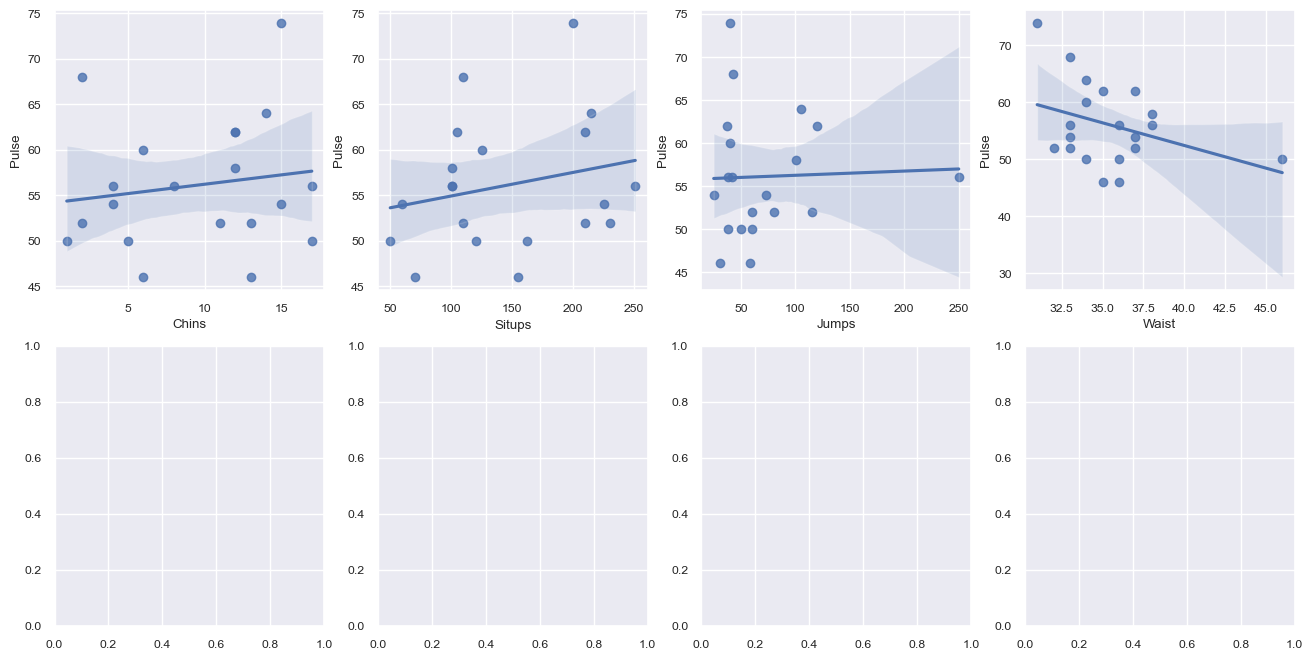

In [64]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

lm_features = ['Chins','Situps','Jumps','Waist']

for i, feature in enumerate(lm_features):
    row = int(i/4) # 2행
    col = i%4

    # sns.regplot : 회귀직선을 그려줌
    sns.regplot(x=feature, y='Pulse', data=df, ax=axs[row][col])

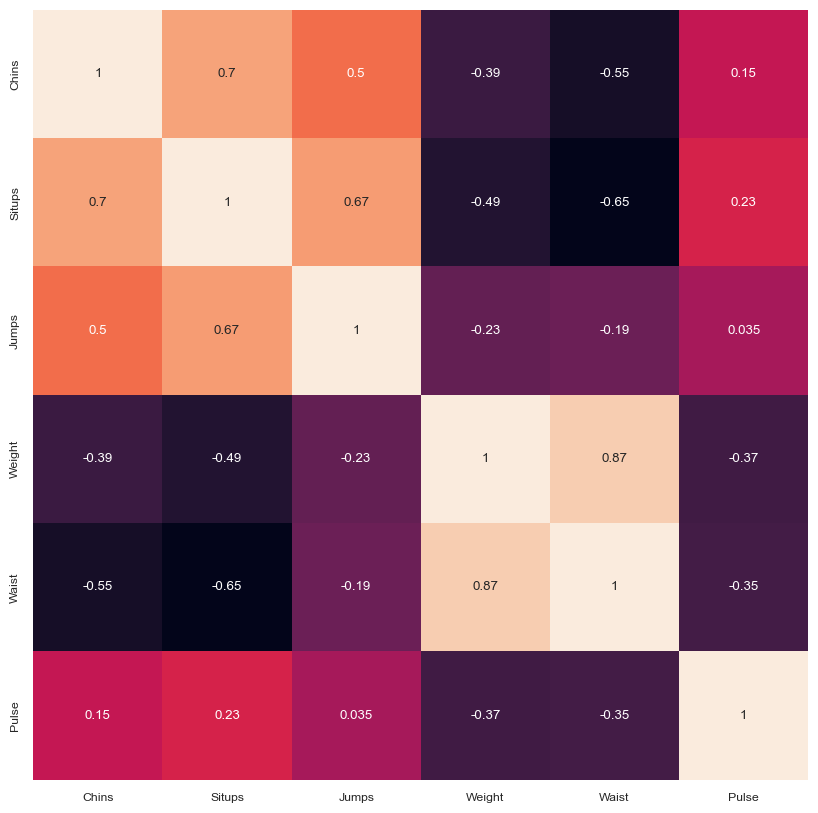

In [65]:
#상관 관계 행렬
df_corr=df.corr()

#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()

In [66]:
X = df.drop('Pulse', axis=1)
y = df['Pulse']

In [67]:
X

,Chins,Situps,Jumps,Weight,Waist
0,5.0,162.0,60.0,191.0,36.0
1,2.0,110.0,60.0,189.0,37.0
2,12.0,101.0,101.0,193.0,38.0
3,12.0,105.0,37.0,162.0,35.0
4,13.0,155.0,58.0,189.0,35.0
5,4.0,101.0,42.0,182.0,36.0
6,8.0,101.0,38.0,211.0,38.0
7,6.0,125.0,40.0,167.0,34.0
8,15.0,200.0,40.0,176.0,31.0
9,17.0,251.0,250.0,154.0,33.0


In [68]:
X.shape

(20, 5)

In [69]:
y

0     50.0
1     52.0
2     58.0
3     62.0
4     46.0
5     56.0
6     56.0
7     60.0
8     74.0
9     56.0
10    50.0
11    52.0
12    64.0
13    50.0
14    46.0
15    62.0
16    54.0
17    52.0
18    54.0
19    68.0
Name: Pulse, dtype: float64

In [70]:
# 데이터 분할
# 먼저, 테스트 세트를 분할 (전체 데이터의 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 나머지 데이터를 훈련용과 검증용으로 분할 (전체 데이터의 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [74]:
# 데이터 정규화 (스케일 조정)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [75]:
# 모델 생성
model = keras.Sequential([
    keras.layers.Input(shape=(5,)),  # 입력 레이어 (3개의 입력 특성)
    keras.layers.Dense(10, activation='relu'),  # 은닉 레이어
    keras.layers.Dense(1)  # 출력 레이어
])
model.summary()

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_val_scaled, y_val))

# 모델 평가
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                60        
                                                                 
 dense_16 (Dense)            (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
1/1 [==============================] - 0s 467ms/step - loss: 3115.1086 - val_loss: 3364.3298
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 3114.0872 - val_loss: 3363.6294
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 3113.0632 - val_loss: 3362.9272
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 3112.0364 - val_loss: 3362.2241
Epoch 5/100
1/1 [==============================] - 0s 32ms/step - loss: 3111.0071 - val_loss: 3361.5193
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 3109.9756 - val_loss: 3360.8125
Epoch 7/100
1/1 [==============================] - 0s 29ms/step - loss: 3108.9412 - val_loss: 3360.1050
Epoch 8/100
1/1 [==============================] - 0s 29ms/step - loss: 3107.9043 - val_loss: 3359.3948
Epoch 9/100
1/1 [==============================] - 0s 32ms/step - loss: 3106.8645 - val_loss: 3358.6836
Epoch 10/100
1/1 [==============================] - 0s 33ms/ste

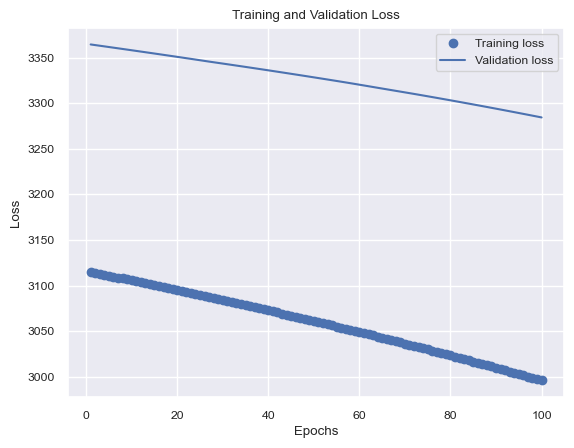

In [76]:
# 그래프를 그리기 위한 데이터
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# 손실 그래프 그리기
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [78]:
# 새로운 입력 데이터
new_data = np.array([[15.0, 225.0, 73.0, 174.0, 33.0]])  # 예시 데이터, 필요에 따라 수정

# 예측
predicted_pulse = model.predict(new_data)
print(f'Predicted Pulse: {predicted_pulse[0][0]}')

1/1 [==============================] - 0s 17ms/step
Predicted Pulse: 372.9806213378906
